In [ ]:
pip install seaborn==0.10.0

     |████████████████████████████████| 225kB 2.8MB/s 
  Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1


In [ ]:
%matplotlib inline
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pip install squarify

In [ ]:
import squarify

In [ ]:
with open('/content/ML Data.txt','rb') as file:
  lines=file.readlines()

In [ ]:
list_=[]
for line in lines:
  line=line.decode("cp1252") 
  items=line.split(',')
  if len(items)>8:
    items=items[:2]+[' '.join(items[2:2+(len(line.split(','))-7)])]+items[-5:]  
  if len(items)==8:
    list_.append(items)
  else:
    if len(list_)>0:
      print(items)
      
    #raise Exception 
    



In [ ]:
# Read dataset
online = pd.DataFrame(list_)

for col in online.columns:
  online[col]=online[col].str.replace('"','')
  online[col]=online[col].str.replace('\r\n','')

online.columns=online.iloc[0]
online=online.iloc[1:]

In [ ]:
online

,Invoice_Number,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country
1,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850,United Kingdom
2,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850,United Kingdom
3,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850,United Kingdom
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850,United Kingdom
5,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
60468,541422,21849,SILVER DIAMANTE PEN IN GIFT BOX,2,1/17/2011 17:48,1.63,,United Kingdom
60469,541422,21850,BLUE DIAMANTE PEN IN GIFT BOX,1,1/17/2011 17:48,1.63,,United Kingdom
60470,541422,21851,LILAC DIAMANTE PEN IN GIFT BOX,2,1/17/2011 17:48,1.63,,United Kingdom
60471,541422,21868,POTTING SHED TEA MUG,1,1/17/2011 17:48,3.29,,United Kingdom


In [ ]:
online.columns

Index(['Invoice_Number', 'Product_Code', 'Description', 'Quantity',
       'Invoice_Date', 'Unit_Price', 'Customer_ID', 'Country'],
      dtype='object', name=0)

In [ ]:
online['Invoice_Date']=pd.to_datetime(online['Invoice_Date'])

In [ ]:

print('{:,} rows; {:,} columns'.format(online.shape[0], online.shape[1]))
print('{:,} transactions don\'t have a customer id'.format(online[online['Customer_ID'].isnull()].shape[0]))
print('Transactions timeframe from {} to {}'.format(online['Invoice_Date'].min(),online['Invoice_Date'].max()))

60,472 rows; 9 columns
0 transactions don't have a customer id
Transactions timeframe from 2010-12-01 08:26:00 to 2011-01-17 17:48:00


In [ ]:
# Create TotalSum column for online dataset
online['Invoice_Value'] = online['Unit_Price'].astype(float) * online['Quantity'].astype(float)
# Create snapshot date
snapshot_date = online['Invoice_Date'].max() + timedelta(days=1)
print(snapshot_date)
# Grouping by CustomerID
data_process = online.groupby(['Customer_ID']).agg({
        'Invoice_Date': lambda x: (snapshot_date - x.max()).days,
        'Quantity': 'count',
        'Invoice_Value': 'sum'})
# Rename the columns 
data_process.rename(columns={'Invoice_Date': 'Recency',
                         'Quantity': 'Frequency',
                         'Invoice_Value': 'MonetaryValue'}, inplace=True)



2011-01-18 17:48:00


In [ ]:
import math

In [ ]:
data_process['MonetaryValue']

Customer_ID
         222210.88
12347       711.79
12348       892.80
12359       547.50
12370      1868.02
           ...    
18256       -50.10
18259       376.30
18260       787.77
18269       138.90
18283       108.45
Name: MonetaryValue, Length: 1166, dtype: float64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


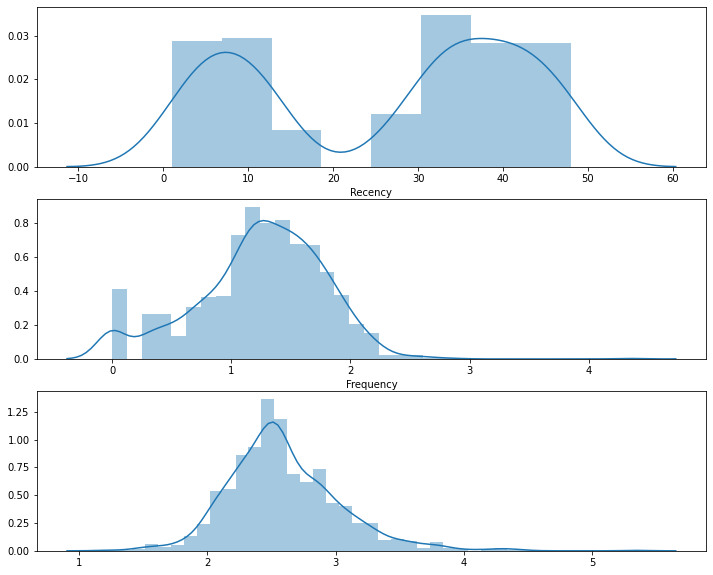

In [ ]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(data_process['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(pd.np.log10(data_process['Frequency']))
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot([pd.np.log10(x) for x in data_process['MonetaryValue'] if x > 0])
# Show the plot
#plt.gcf()

In [ ]:
data_process.to_csv('RFMScores.csv')

In [ ]:
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(data_process['Recency'], q=4,labels=r_labels, duplicates='drop')
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels,duplicates='drop')
# Create new columns R and F 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values)
data_process.head()

,Recency,Frequency,MonetaryValue,R,F
Customer_ID,,,,,
,1,22423,222210.88,4,4
12347,42,31,711.79,1,3
12348,32,17,892.80,3,2
12359,6,16,547.50,4,2
12370,32,91,1868.02,3,4


In [ ]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(data_process['MonetaryValue'], q=4, labels=m_labels)
# Create new column M
data_process = data_process.assign(M = m_groups.values)

In [ ]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
data_process['RFM_Segment_Concat'] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat
Customer_ID,,,,,,,
,1,22423,222210.88,4,4,4,444
12347,42,31,711.79,1,3,4,134
12348,32,17,892.80,3,2,4,324
12359,6,16,547.50,4,2,3,423
12370,32,91,1868.02,3,4,4,344


In [ ]:
rfm.to_csv('rfm.csv')

In [ ]:
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_count_unique.sum())

63


In [ ]:
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

Customer_ID
         12.0
12347     8.0
12348     9.0
12359     9.0
12370    11.0
Name: RFM_Score, dtype: float64


In [ ]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] > 11:
        return 'Top Customers : Can\'t Loose Them'
    elif ((df['RFM_Score'] > 9) and (df['RFM_Score'] <= 11)):
        return 'Champions : They Drive our business'
    elif ((df['RFM_Score'] > 8) and (df['RFM_Score'] <= 10)):
        return 'Loyal Customers: They Drive our business'
    elif ((df['RFM_Score'] > 6) and (df['RFM_Score'] <= 8)):
        return 'Potential:  promotional efforts needed'
    elif ((df['RFM_Score'] > 4) and (df['RFM_Score'] <= 6)):
        return'Needs Attention: You may loose these cusomers soon'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
Customer_ID,,,,,,,,,
,1,22423,222210.88,4,4,4,444,12.0,Top Customers : Can't Loose Them
12347,42,31,711.79,1,3,4,134,8.0,Potential: promotional efforts needed
12348,32,17,892.80,3,2,4,324,9.0,Loyal Customers: They Drive our business
12359,6,16,547.50,4,2,3,423,9.0,Loyal Customers: They Drive our business
12370,32,91,1868.02,3,4,4,344,11.0,Champions : They Drive our business


In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                                                   Recency  ... MonetaryValue
                                                      mean  ...         count
RFM_Level                                                   ...              
Champions : They Drive our business                   14.1  ...           220
Loyal Customers: They Drive our business              22.3  ...           114
Needs Attention: You may loose these cusomers soon    32.5  ...           264
Potential:  promotional efforts needed                27.9  ...           313
Require Activation                                    41.3  ...           171
Top Customers : Can't Loose Them                       5.4  ...            84

[6 rows x 4 columns]


In [ ]:
rfm_level_agg.to_csv('rfm_segments.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  import sys


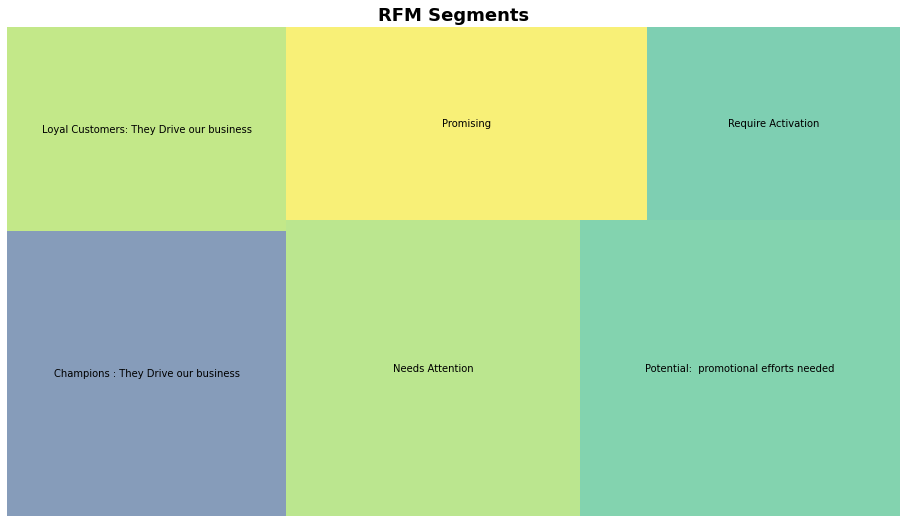

In [ ]:
import matplotlib.pyplot as plt
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=pd.np.sqrt(rfm_level_agg['Count']), 
              label=['Champions : They Drive our business',
'Loyal Customers: They Drive our business',              
'Needs Attention',  
'Potential:  promotional efforts needed',                
'Promising',   
'Require Activation',                                  
'Top Customers : Can\'t Loose Them '   ], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [ ]:
rfm_level_agg

,RecencyMean,FrequencyMean,MonetaryMean,Count
RFM_Level,,,,
Champions : They Drive our business,14.1,53.0,1089.6,220
Loyal Customers: They Drive our business,22.3,40.8,1053.0,114
Needs Attention: You may loose these cusomers soon,32.5,12.6,211.3,264
Potential: promotional efforts needed,27.9,26.7,486.9,313
Require Activation,41.3,5.0,74.2,171
Top Customers : Can't Loose Them,5.4,376.6,5643.4,84


In [ ]:
online

,Invoice_Number,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Invoice_Value
1,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
2,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
3,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
5,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
60468,541422,21849,SILVER DIAMANTE PEN IN GIFT BOX,2,2011-01-17 17:48:00,1.63,,United Kingdom,3.26
60469,541422,21850,BLUE DIAMANTE PEN IN GIFT BOX,1,2011-01-17 17:48:00,1.63,,United Kingdom,1.63
60470,541422,21851,LILAC DIAMANTE PEN IN GIFT BOX,2,2011-01-17 17:48:00,1.63,,United Kingdom,3.26
60471,541422,21868,POTTING SHED TEA MUG,1,2011-01-17 17:48:00,3.29,,United Kingdom,3.29


In [ ]:
online['Date']=pd.to_datetime(online['Invoice_Date']).dt.floor('d')
online['Quantity']=online.Quantity.astype(float)
big_picture=online.groupby(['Date']).agg({'Quantity':'sum','Invoice_Value':'sum'})

In [ ]:
big_picture['Visits']=online['Date'].value_counts()

In [ ]:
big_picture=big_picture.reset_index()

big_picture['Date']=pd.to_datetime(big_picture['Date'])


In [ ]:
big_picture

,Date,Quantity,Invoice_Value,Visits
0,2010-12-01,26814.0,58635.56,3108
1,2010-12-02,21023.0,46207.28,2109
2,2010-12-03,14830.0,45620.46,2202
3,2010-12-05,16395.0,31383.95,2725
4,2010-12-06,21419.0,53860.18,3878
5,2010-12-07,24995.0,45059.05,2963
6,2010-12-08,22741.0,44189.84,2647
7,2010-12-09,18431.0,52532.13,2891
8,2010-12-10,20297.0,57404.91,2758
9,2010-12-12,10565.0,17240.92,1451


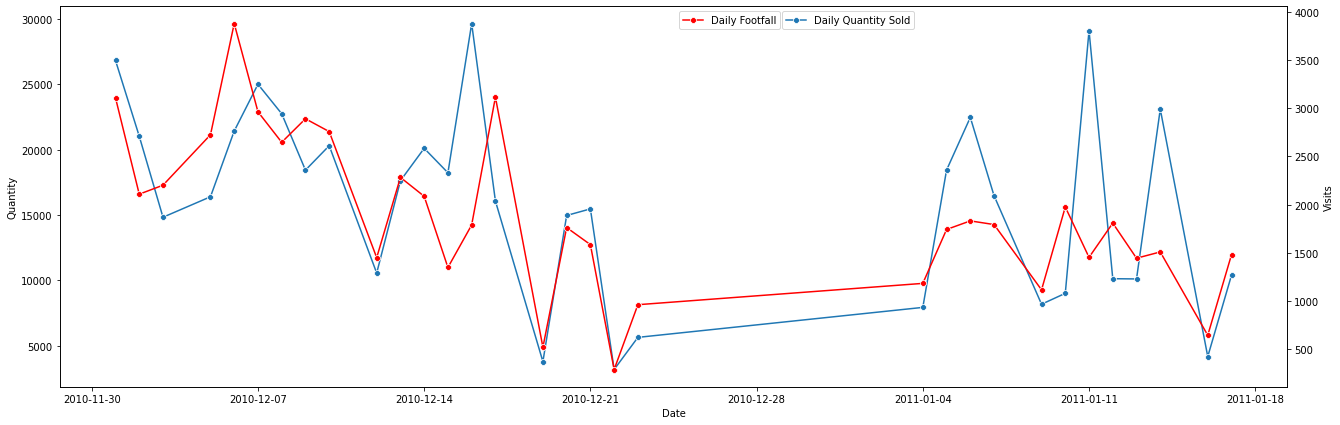

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

plt.figure(figsize=(22,7))
big_picture=big_picture.sort_values(by='Date')

date_form = DateFormatter("%m-%Y")
ax.grid(True)
ax.xaxis.set_major_formatter(date_form)

ax = sns.lineplot(x="Date", y="Quantity", data=big_picture,marker='8',label='Daily Quantity Sold')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
plt.legend(loc=1,bbox_to_anchor=(0.7,1))
#ax2=ax.twinx()
#ax2=sns.lineplot(x="Date", y="Invoice Value", data=big_picture,color='red',label='Invoice Value')
#ax2.xaxis.set_major_locator(mdates.MonthLocator())


ax3=ax.twinx()
ax3=sns.lineplot(x="Date", y="Visits", data=big_picture,color='red',label='Daily Footfall',marker='8')
ax3.xaxis.set_major_locator(mdates.WeekdayLocator())
plt.legend(loc=2,bbox_to_anchor=(0.5,1))
plt.show()






In [ ]:
big_picture['weekday']=big_picture.Date.dt.day_name()

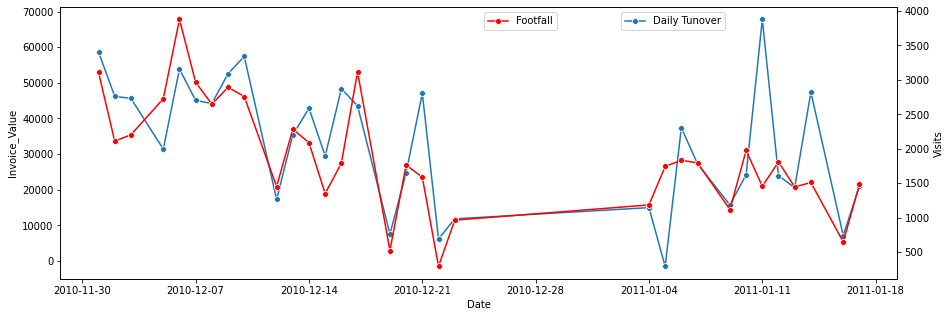

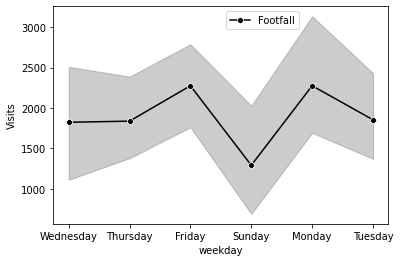

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


plt.figure(figsize=(15,5))
big_picture=big_picture.sort_values(by='Date')

date_form = DateFormatter("%m-%Y")
ax.grid(True)
ax.xaxis.set_major_formatter(date_form)

ax = sns.lineplot(x="Date", y="Invoice_Value", data=big_picture,marker='8',label='Daily Tunover')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
plt.legend(loc=1,bbox_to_anchor=(0.8,1))
#ax2=ax.twinx()
#ax2=sns.lineplot(x="Date", y="Invoice Value", data=big_picture,color='red',label='Invoice Value')
#ax2.xaxis.set_major_locator(mdates.MonthLocator())


ax3=ax.twinx()
ax3=sns.lineplot(x="Date", y="Visits", data=big_picture,color='red',label='Footfall',marker='8')
ax3.xaxis.set_major_locator(mdates.WeekdayLocator())
plt.legend(loc=2,bbox_to_anchor=(0.5,1))
plt.show()



ax3=ax.twiny()
ax3=sns.lineplot(x="weekday", y="Visits", data=big_picture,color='black',label='Footfall',marker='8',sort= False)
#ax3.set_xticklabels(["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday"])
#ax3.xaxis.set_major_locator(mdates.WeekdayLocator())
plt.legend(loc=2,bbox_to_anchor=(0.5,1))
plt.show()






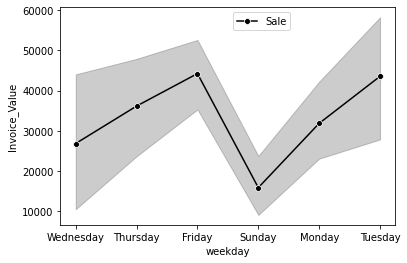

In [ ]:
ax3=ax.twiny()
ax3=sns.lineplot(x="weekday", y="Invoice_Value", data=big_picture,color='black',label='Sale',marker='8',sort=False)
#ax3.xaxis.set_major_locator(mdates.WeekdayLocator())
plt.legend(loc=2,bbox_to_anchor=(0.5,1))
plt.show()

In [ ]:
data_process

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
Customer_ID,,,,,,,,,
,1,22423,222210.88,4,4,4,444,12.0,Top Customers : Can't Loose Them
12347,42,31,711.79,1,3,4,134,8.0,Potential: promotional efforts needed
12348,32,17,892.80,3,2,4,324,9.0,Loyal Customers: They Drive our business
12359,6,16,547.50,4,2,3,423,9.0,Loyal Customers: They Drive our business
12370,32,91,1868.02,3,4,4,344,11.0,Champions : They Drive our business
...,...,...,...,...,...,...,...,...,...
18256,29,4,-50.10,3,1,1,311,5.0,Needs Attention: You may loose these cusomers ...
18259,41,7,376.30,1,1,3,113,5.0,Needs Attention: You may loose these cusomers ...
18260,9,37,787.77,4,3,4,434,11.0,Champions : They Drive our business


In [ ]:
online

,Invoice_Number,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Invoice_Value,Date
1,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01
2,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01
3,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01
5,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01
...,...,...,...,...,...,...,...,...,...,...
60468,541422,21849,SILVER DIAMANTE PEN IN GIFT BOX,2.0,2011-01-17 17:48:00,1.63,,United Kingdom,3.26,2011-01-17
60469,541422,21850,BLUE DIAMANTE PEN IN GIFT BOX,1.0,2011-01-17 17:48:00,1.63,,United Kingdom,1.63,2011-01-17
60470,541422,21851,LILAC DIAMANTE PEN IN GIFT BOX,2.0,2011-01-17 17:48:00,1.63,,United Kingdom,3.26,2011-01-17
60471,541422,21868,POTTING SHED TEA MUG,1.0,2011-01-17 17:48:00,3.29,,United Kingdom,3.29,2011-01-17


In [ ]:
online=online.sort_values(by=['Date'])

In [ ]:
online.reset_index(inplace=True,drop=True)

In [ ]:
online.fillna(0,inplace=True)
online['Date'].replace(0,pd.np.nan,inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


In [ ]:

data_p = online.groupby(['Customer_ID']).agg({
#          'InvoiceDate': lambda x: (x.nlargest(1,keep='first') - x.nlargest(2,keep='first').iloc[-1]).max().days,
          'Quantity': 'cumsum',
          'Invoice_Value': 'cumsum'})

In [ ]:
online['Date'].fillna(method='ffill', inplace=True)

In [ ]:
ls = online.groupby('Customer_ID')['Date'].diff()

In [ ]:
ls=pd.to_numeric(ls.dt.days, downcast='integer')

In [ ]:
ls.fillna(pd.np.inf,inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


In [ ]:
data_p.rename({'Quantity':'Cum_Quality','Invoice_Value':'Cum_Invoice'},inplace=True,axis=1)
data=pd.merge(online,data_p,left_index=True,right_index=True)

In [ ]:
data['time_last_seen']=ls

In [ ]:
data['#visits']=data.groupby('Customer_ID').agg({'Customer_ID':'cumcount'})

In [ ]:

data.Cum_Quality=data.Cum_Quality-data.Quantity
data.Cum_Invoice=data.Cum_Invoice-data['Invoice_Value']

In [ ]:
data['Purchased']=data.Quantity>0

In [ ]:
import numpy as np

In [ ]:
list_data=[]
i=0
for customer_id in data['Customer_ID'].unique():
  df_cust=data.loc[data['Customer_ID']==customer_id,:]
  df_cust=df_cust.sort_index()
  df_cust.loc[df_cust.index[0],'last_purchase_since']=pd.np.inf
  i+=1
  print(df_cust)
  if(i>5):
    break

  df_cust['last_purchased_date']=df_cust.loc[df_cust['Purchased'],'Date']
  df_cust['last_purchased_date'].fillna(method='ffill',inplace=True)
  df_cust.loc[df_cust['Purchased'],'last_purchased_date']=pd.np.nan
  df_cust['last_purchased_date'].fillna(method='bfill',inplace=True)
  df_cust['last_purchase_since']=df_cust['Date']-df_cust['last_purchased_date']
  df_cust.last_purchase_since=pd.to_numeric(df_cust.last_purchase_since.dt.days, downcast='integer')
  df_cust.loc[df_cust['last_purchase_since']<0,'last_purchase_since']=pd.np.nan
  df_cust['last_purchase_since'].fillna(np.inf,inplace=True)
  list_data.append(df_cust)
  
  #data.loc[data['Customer ID']==customer_id,'last_purchase_since']=



In [ ]:
df_data=df = pd.concat(list_data)

In [ ]:
df_data.to_csv('featureset.csv')

In [ ]:
pd.to_numeric(df_data.last_purchase_since.dt.days, downcast='integer')

In [ ]:
df_data